# Height Profile

## Imports

In [1]:
%matplotlib inline
from netCDF4 import Dataset, num2date
import matplotlib.pyplot as plt
import numpy as np
import datetime
import pandas as pd
from sklearn.neighbors import NearestNeighbors
import numpy.ma as ma
from matplotlib.colors import ListedColormap
from datetime import datetime, timedelta
import matplotlib
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import os
import math
from datetime import datetime, timedelta

## Annahmen

In [2]:
dateBegin = datetime(2020, 1, 1)
dateEnd = datetime(2020, 1, 31)

## abgeleitete Variablen

In [3]:
days = np.arange(dateBegin, dateEnd, timedelta(days=1)).astype(datetime)
hours = np.arange(dateBegin, dateEnd, timedelta(hours=0.5)).astype(datetime)
#print(days)
timeseries = []
heightTimeseries = np.zeros((len(days),300))
heightGrid = list(range(0,15000,50))
heightGridDf = pd.DataFrame({'height': heightGrid})

## Funktionsdefinitionen

In [4]:
def mergeHeight(heightList):
    # map height
    knn = NearestNeighbors(n_neighbors=1)
    knn.fit(heightList)
    return knn.kneighbors(heightGridDf, return_distance=False)

In [5]:
gridTimeSeries = []
for entry in hours:
    gridTimeSeries.append(datetime.timestamp(entry))
gridDf = pd.DataFrame({'time': gridTimeSeries})  
def timeknn(TimeSeries):

    
    
    
    #Target Grid
    targetTimeList = []
    for entry in TimeSeries:
        stamp = (entry-2440587.5)*86400
        targetTimeList.append(stamp)
    targetDf = pd.DataFrame({'time': targetTimeList})
    
    #KNN
    knn = NearestNeighbors(n_neighbors=1)
    knn.fit(targetDf)
    matchList = knn.kneighbors(gridDf, return_distance=True)
    

    #generate result
    resultList = []
    for i in range(len(gridTimeSeries)):
        iMatch = int(matchList[1][i])
        if matchList[0][i] <= 60*14: #14 Minuten
            resultList.append(iMatch)
        else:
            resultList.append(np.nan)
    return resultList

In [6]:
radarList = np.zeros(300)
lidarList = np.zeros(300)
both = np.zeros(300)

def readFile(pathRadar, pathLidar):
    #Radar
    if os.path.exists(pathRadar):
        datasetRadar = Dataset(pathRadar, mode='r')
        heightRadar = datasetRadar.variables['height'][:]
        heightRadarDf = pd.DataFrame({'height': heightRadar})
        speedRadar = datasetRadar.variables['speed'][:]
        speedRadar = speedRadar.filled(np.nan)
        timeRadar = datasetRadar.variables['time'][:]
        speedRadar = speedRadar.T
        matchRadarIndex = mergeHeight(heightRadarDf)
        matchRadarTimeIndex = timeknn(timeRadar)
    #Lidar
    if os.path.exists(pathLidar):
        datasetLidar = Dataset(pathLidar, mode='r')
        heightLidar = datasetLidar.variables['height'][:]
        heightLidarDf = pd.DataFrame({'height': heightLidar})
        speedLidar = datasetLidar.variables['speed'][:]
        speedLidar = speedLidar.filled(np.nan)
        timeLidar = datasetLidar.variables['time'][:]
        matchLidarIndex = mergeHeight(heightLidarDf)
        matchLidarTimeIndex = timeknn(timeLidar)
    if os.path.exists(pathLidar) and os.path.exists(pathRadar):
        for nHour in range(len(hours)):
            for i in range(0,300):
                iMatchRadar = matchRadarIndex[i]
                nMatchRadar = matchRadarTimeIndex[nHour]
                iMatchLidar = matchLidarIndex[i]
                nMatchLidar = matchLidarTimeIndex[nHour]
                if not math.isnan(iMatchRadar):
                    if not math.isnan(nMatchRadar):
                        if not math.isnan(speedRadar[iMatchRadar,nMatchRadar]):
                            radarList[i] +=1
                if not math.isnan(iMatchLidar):
                    if not math.isnan(nMatchLidar):
                        if not math.isnan(speedLidar[iMatchLidar,nMatchLidar]):
                            lidarList[i] +=1
                if not math.isnan(iMatchRadar) and not math.isnan(iMatchLidar):
                    if not math.isnan(nMatchRadar) and not math.isnan(nMatchLidar):
                        if not math.isnan(speedRadar[iMatchRadar,nMatchRadar]) and not math.isnan(speedLidar[iMatchLidar,nMatchLidar]):
                            both[i] +=1


## Funktionsaufruf

In [7]:
for n in range(len(days)):
    day = days[n]
    pathRadar = '/data/obs/site/jue/joyrad35/wind_ppi/data/'+day.strftime("%Y")+'/'+day.strftime("%m")+'/'+day.strftime("%Y%m%d")+'_joyrad35_wind_profile.nc'
    pathLidar = '/data/obs/site/jue/wind_lidar/l1/'+day.strftime("%Y")+'/'+day.strftime("%m")+'/'+day.strftime("%d")+'/wind_vad-36_'+day.strftime("%Y%m%d")+'.nc'
    readFile(pathRadar,pathLidar)

In [8]:
totalList = np.zeros(300)
totalList = radarList+lidarList-both

In [9]:
radarList = radarList/len(hours)*100
lidarList = lidarList/len(hours)*100
totalList = totalList/len(hours)*100

## Plot

<ipython-input-10-3a2dfd25e364>:5: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  axes = plt.axes()


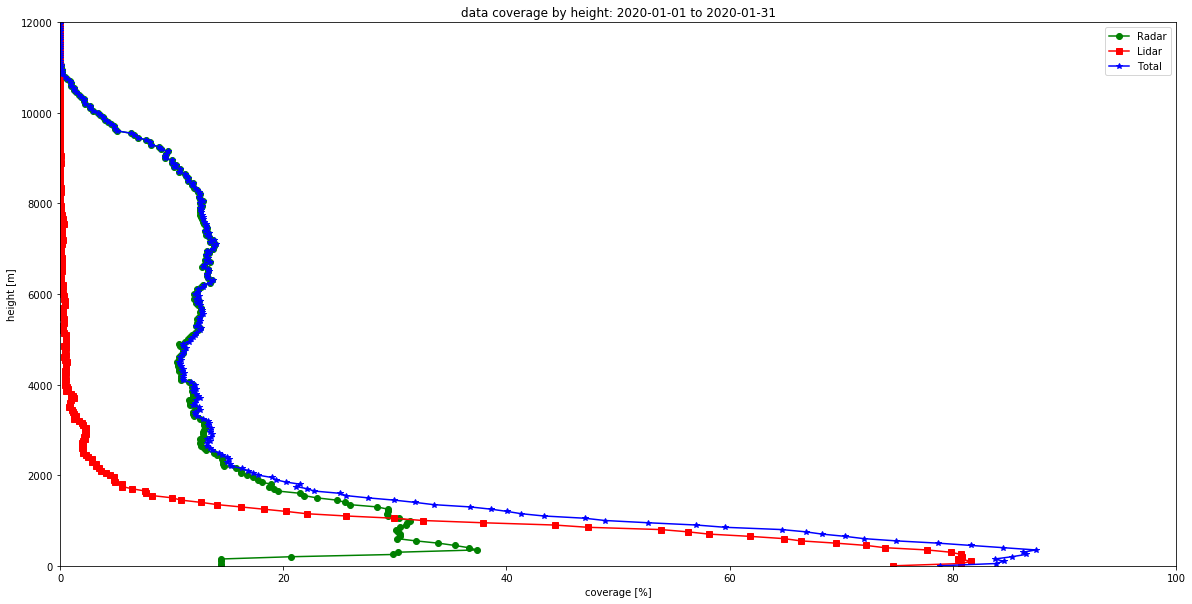

In [10]:
plt.figure(figsize=(20,10))
plt.plot(radarList,heightGrid, 'go-', label='Radar')
plt.plot(lidarList,heightGrid, 'rs-', label='Lidar')
plt.plot(totalList,heightGrid, 'b*-', label='Total')
axes = plt.axes()
axes.set_ylim([0, 12000])
axes.set_xlim([0, 100])
plt.xlabel("coverage [%]")
plt.ylabel("height [m]")
plt.legend()
plt.title('data coverage by height: '+dateBegin.strftime("%Y-%m-%d")+" to "+dateEnd.strftime("%Y-%m-%d"))
plt.show()